1. Imports and Device Configuration


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Sử dụng thiết bị: {device}')

Sử dụng thiết bị: cuda


2. Data Loading and Preparation (CIFAR-10)

In [ ]:
# Define image transformations for the training set (with Data Augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=1), # Randomly crop 32x32 image after adding 1 pixel padding
    transforms.RandomHorizontalFlip(),    # Randomly flip image horizontally
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize pixel values to [-1, 1]
])

# Define image transformations for the test/validation set (normalization only)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training dataset (applying transform_train)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Download and load the test dataset (applying transform_test)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Split the training set into training and validation sets
val_split = 0.1 # 10% of training data for validation
train_size = int((1 - val_split) * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Define batch size
batch_size = 128 # Batch size, can be adjusted

# Create DataLoaders for the datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f'Data loaded and prepared. Training set size: {len(train_dataset)}, validation: {len(val_dataset)}, test: {len(testset)}')

Data loaded and prepared. Training set size: 45000, validation: 5000, test: 10000


3. MLP Model Definition with Dropout

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        # Flatten layer
        self.flatten = nn.Flatten()
        # Define Linear (Fully Connected) layers and add Dropout
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3) # Add Dropout with p=0.3

        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3) # Add Dropout with p=0.3

        self.fc3 = nn.Linear(256, num_classes) # Output layer

    def forward(self, x):
        x = self.flatten(x)# Flatten image
        x = self.fc1(x)    # Linear Layer 1
        x = self.relu1(x)  # ReLU 1 activation function
        x = self.dropout1(x) # Apply Dropout

        x = self.fc2(x)     # Linear Layer 2
        x = self.relu2(x)   # ReLU 2 activation function
        x = self.dropout2(x) # Apply Dropout

        x = self.fc3(x)     # Output layer

        return x

4.  CNN Model Definition with Dropout

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # 3 Convolutional layers (Conv) + ReLU + Pooling
        self.conv_layers = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Input: 3x32x32, Output: 32x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # Output: 32x16x16

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Input: 32x16x16, Output: 64x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),    # Output: 64x8x8

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Input: 64x8x8, Output: 128x8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)     # Output: 128x4x4
        )

        # Input dimension for the Fully Connected layer after flattening
        # With 3 Pooling layers, the final dimension is 4x4
        self.fc_input_dim = 128 * 4 * 4 # Input dimension for the Fully Connected layer

        # Add Dropout before the final Fully Connected layer
        self.dropout_fc = nn.Dropout(p=0.3) # Add Dropout with p=0.3

        # Final Fully Connected layer
        self.fc = nn.Linear(self.fc_input_dim, num_classes)

    def forward(self, x):
        x = self.conv_layers(x) # Pass through convolutional and pooling layers
        x = x.view(-1, self.fc_input_dim) # Flatten
        x = self.dropout_fc(x) # Apply Dropout before FC layer
        x = self.fc(x) # Pass through Fully Connected layer
        return x

5. Model Training Function

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    model.to(device) # Move model to device (CPU/GPU)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f'Starting training for {model.__class__.__name__} model for {num_epochs} epochs...')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode (Dropout is enabled)
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move data and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad() # Clear previous gradients
            loss.backward()       # Compute gradients
            optimizer.step()      # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # --- Validation Phase ---
        model.eval() # Set model to evaluation mode (Dropout is disabled)
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad(): # Do not compute gradients during evaluation
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(valloader)
        epoch_val_acc = 100 * correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    print('Training complete.')
    return train_losses, val_losses, train_accuracies, val_accuracies

6. Model Testing Function

In [ ]:
def test_model(model, test_loader):
    model.to(device) # Move model to device
    model.eval() # Set model to evaluation mode (Dropout is disabled)
    correct_test = 0
    total_test = 0
    all_predicted = []
    all_labels = []

    print(f'Starting testing for {model.__class__.__name__} model...')

    with torch.no_grad(): # Do not compute gradients during testing
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct_test / total_test
    print(f'Test accuracy for {model.__class__.__name__} model: {test_acc:.2f}%')

    return all_labels, all_predicted,test_acc # Return true labels and predictions for confusion matrix

7. Plot Learning Curves Function

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'Learning Curve - Loss ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'Learning Curve - Accuracy ({model_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


8. Plot Confusion Matrix Function

In [ ]:
def plot_confusion_matrix(all_labels, all_predicted, classes, model_name):
    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix ({model_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

9. Main Execution Block

In [ ]:
# Training configuration
num_epochs = 20 # Number of epochs for training
learning_rate = 0.001 # Learning rate


--- Training MLP Model ---
Starting training for MLP model for 20 epochs...
Epoch [1/20], Train Loss: 1.7715, Train Acc: 36.62%, Val Loss: 1.6343, Val Acc: 41.54%
Epoch [2/20], Train Loss: 1.6234, Train Acc: 42.57%, Val Loss: 1.5313, Val Acc: 45.84%
Epoch [3/20], Train Loss: 1.5696, Train Acc: 44.48%, Val Loss: 1.5116, Val Acc: 46.44%
Epoch [4/20], Train Loss: 1.5296, Train Acc: 45.88%, Val Loss: 1.4769, Val Acc: 48.24%
Epoch [5/20], Train Loss: 1.5020, Train Acc: 46.76%, Val Loss: 1.4363, Val Acc: 49.30%
Epoch [6/20], Train Loss: 1.4802, Train Acc: 47.74%, Val Loss: 1.4242, Val Acc: 49.78%
Epoch [7/20], Train Loss: 1.4638, Train Acc: 48.06%, Val Loss: 1.4147, Val Acc: 50.06%
Epoch [8/20], Train Loss: 1.4441, Train Acc: 48.78%, Val Loss: 1.4039, Val Acc: 50.70%
Epoch [9/20], Train Loss: 1.4337, Train Acc: 49.04%, Val Loss: 1.3898, Val Acc: 50.66%
Epoch [10/20], Train Loss: 1.4142, Train Acc: 49.91%, Val Loss: 1.3807, Val Acc: 50.86%
Epoch [11/20], Train Loss: 1.4097, Train Acc: 49.86%

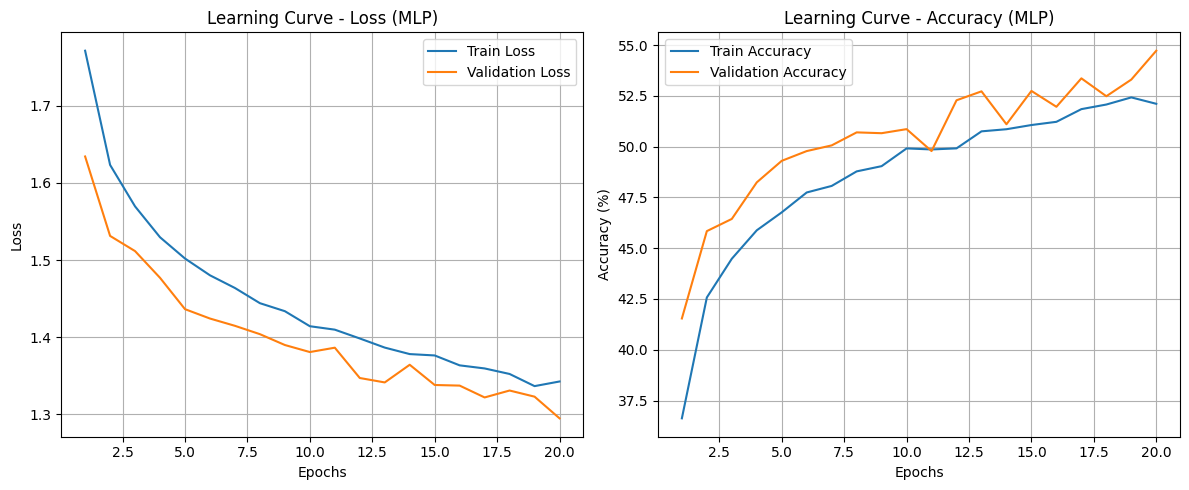

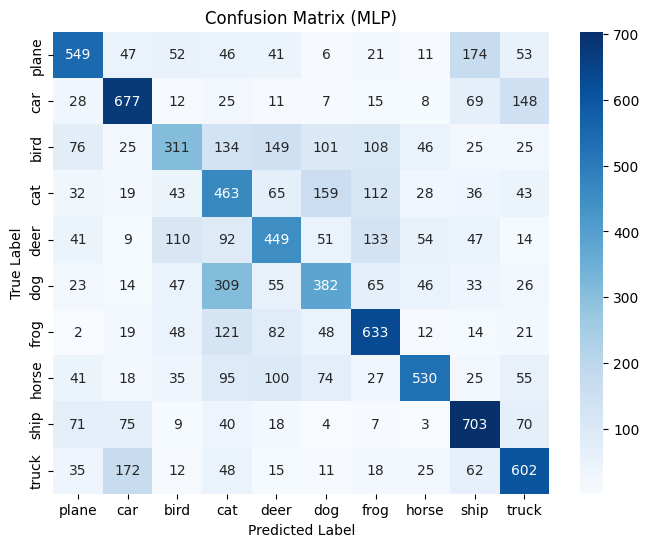

In [ ]:
# --- Train and Evaluate MLP Model ---
print("\n--- Training MLP Model ---")
model_mlp = MLP(num_classes=10)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=learning_rate) # Using Adam for simplicity

train_losses_mlp, val_losses_mlp, train_accuracies_mlp, val_accuracies_mlp = train_model(
    model_mlp, criterion_mlp, optimizer_mlp, trainloader, valloader, num_epochs=num_epochs
)
#Save model
PATH_MLP = './mlp_cifar10.pth'
torch.save(model_mlp.state_dict(), PATH_MLP)
print(f"MLP model saved to {PATH_MLP}")

# Test MLP and get results for confusion matrix
all_labels_mlp, all_predicted_mlp,mlp_test_accuracy = test_model(model_mlp, testloader)

# --- Display Precision, Recall, F1-score for MLP ---
print("\n--- MLP Classification Report ---")
try:
    report_mlp = classification_report(all_labels_mlp, all_predicted_mlp, target_names=classes, zero_division=0)
    print(report_mlp)
except ValueError as e:
    print(f"Error creating classification report for MLP: {e}")
    print("Check if `classes` matches the labels in `all_labels_mlp` and `all_predicted_mlp`.")
    report_mlp_no_names = classification_report(all_labels_mlp, all_predicted_mlp, zero_division=0)
    print("\n--- MLP Classification Report (no class names) ---")
    print(report_mlp_no_names)

# Plot learning curves for MLP
plot_learning_curves(train_losses_mlp, val_losses_mlp, train_accuracies_mlp, val_accuracies_mlp, "MLP")

# Plot confusion matrix for MLP
plot_confusion_matrix(all_labels_mlp, all_predicted_mlp, classes, "MLP")

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

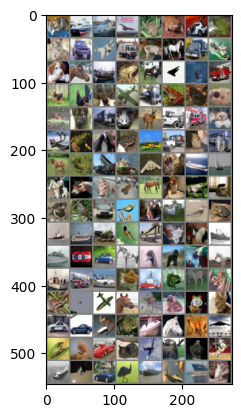

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat  
Predicted:  cat   truck ship  plane deer  frog  car   frog  dog   car   ship  car   cat   horse truck ship  cat   cat   ship  frog  car   plane plane truck deer  frog  dog   plane car   frog  cat   deer  ship  dog   tr

In [ ]:
# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images and labels to the device (GPU if available)
images = images.to(device)
labels = labels.to(device)

# Display images (move to CPU before using matplotlib)
imshow(torchvision.utils.make_grid(images.cpu()))

# Print actual labels (Ground Truth)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# Get predictions from the last trained MLP model
# Ensure 'model_mlp' is the model you want to test (already trained and on 'device')
model_mlp.eval() # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_mlp(images)

# Get predicted labels (index of the highest energy output)
_, predicted = torch.max(outputs, 1)

# Print predicted labels
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))


--- Training CNN Model ---
Starting training for CNN model for 20 epochs...
Epoch [1/20], Train Loss: 1.5605, Train Acc: 43.50%, Val Loss: 1.3141, Val Acc: 53.32%
Epoch [2/20], Train Loss: 1.2110, Train Acc: 56.84%, Val Loss: 1.1307, Val Acc: 60.18%
Epoch [3/20], Train Loss: 1.0426, Train Acc: 63.29%, Val Loss: 1.0390, Val Acc: 64.56%
Epoch [4/20], Train Loss: 0.9460, Train Acc: 66.86%, Val Loss: 0.8916, Val Acc: 69.52%
Epoch [5/20], Train Loss: 0.8797, Train Acc: 69.55%, Val Loss: 0.8641, Val Acc: 70.68%
Epoch [6/20], Train Loss: 0.8296, Train Acc: 71.23%, Val Loss: 0.7993, Val Acc: 72.90%
Epoch [7/20], Train Loss: 0.7913, Train Acc: 72.46%, Val Loss: 0.7793, Val Acc: 73.42%
Epoch [8/20], Train Loss: 0.7570, Train Acc: 73.70%, Val Loss: 0.7663, Val Acc: 73.48%
Epoch [9/20], Train Loss: 0.7282, Train Acc: 74.74%, Val Loss: 0.7212, Val Acc: 75.44%
Epoch [10/20], Train Loss: 0.7064, Train Acc: 75.55%, Val Loss: 0.7242, Val Acc: 75.66%
Epoch [11/20], Train Loss: 0.6829, Train Acc: 76.37%

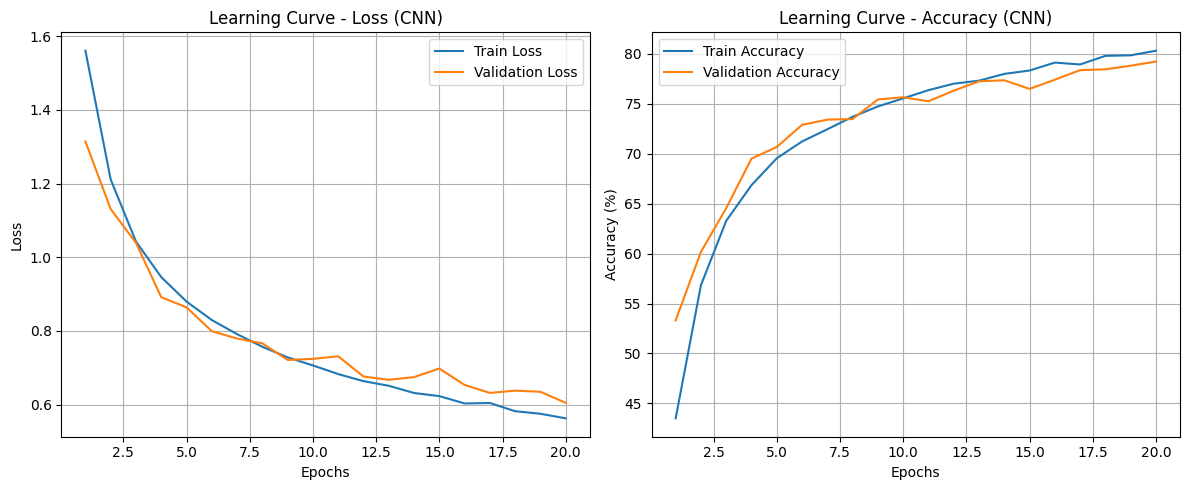

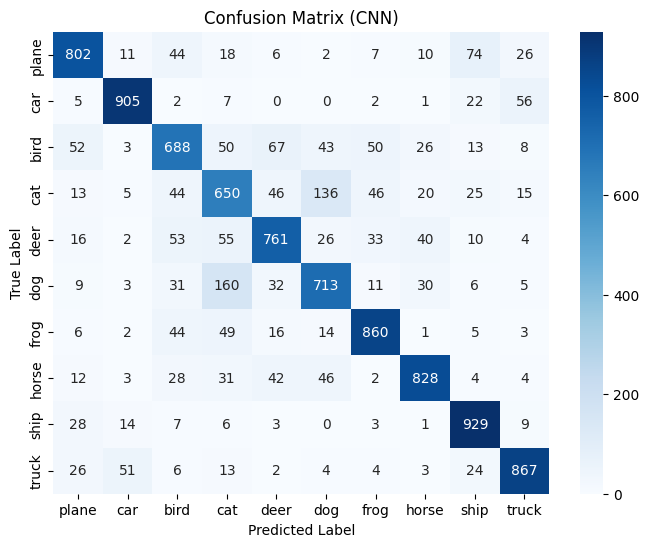

In [ ]:
# --- Train and Evaluate CNN Model ---
print("\n--- Training CNN Model ---")
model_cnn = CNN(num_classes=10)
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate) # Using Adam for simplicity

train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = train_model(
    model_cnn, criterion_cnn, optimizer_cnn, trainloader, valloader, num_epochs=num_epochs
)
#Save model
PATH_CNN = './cnn_cifar10.pth'
torch.save(model_cnn.state_dict(), PATH_CNN)
print(f"CNN model saved to {PATH_CNN}")

# Test CNN and get results for confusion matrix
all_labels_cnn, all_predicted_cnn,cnn_test_accuracy = test_model(model_cnn, testloader)

# --- Display Precision, Recall, F1-score for CNN ---
print("\n--- CNN Classification Report ---")
try:
    report_cnn = classification_report(all_labels_cnn, all_predicted_cnn, target_names=classes, zero_division=0)
    print(report_cnn)
except ValueError as e:
    print(f"Error creating classification report for CNN: {e}")
    print("Check if `classes` matches the labels in `all_labels_cnn` and `all_predicted_cnn`.")
    report_cnn_no_names = classification_report(all_labels_cnn, all_predicted_cnn, zero_division=0)
    print("\n--- CNN Classification Report (no class names) ---")
    print(report_cnn_no_names)

# Plot learning curves for CNN
plot_learning_curves(train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn, "CNN")

# Plot confusion matrix for CNN
plot_confusion_matrix(all_labels_cnn, all_predicted_cnn, classes, "CNN")

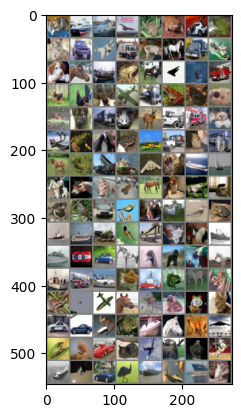

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat   frog  bird  car   bird  cat   horse bird  frog  ship  ship  plane bird  truck cat   cat   ship  ship  car   car   horse bird  dog   bird  horse ship  truck plane cat   ship  frog  deer  frog  frog  plane plane horse deer  dog   frog  cat   car   car   cat   frog  ship  horse deer  plane frog  bird  car   cat   plane deer  bird  horse ship  cat   car   bird  ship  plane ship  cat  
Predicted:  cat   ship  ship  plane frog  frog  car   deer  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck deer  bird  deer  plane truck frog  frog  dog   deer  dog   tr

In [ ]:
# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Move images and labels to the device (GPU if available)
images = images.to(device)
labels = labels.to(device)

# Display images (move to CPU before using matplotlib)
imshow(torchvision.utils.make_grid(images.cpu()))

# Print actual labels (Ground Truth)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# Get predictions from the last trained CNN model
# Ensure 'model_cnn' is the model you want to test (already trained and on 'device')
model_cnn.eval() # Set the model to evaluation mode
with torch.no_grad():
    outputs = model_cnn(images)

# Get predicted labels (index of the highest energy output)
_, predicted = torch.max(outputs, 1)

# Print predicted labels
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(len(predicted))))

# Mục mới

In [ ]:
#Compare and discuss the results of the two neural networks ---
print("\n\n--- FINAL RESULTS COMPARISON ---")
print(f"MLP Test Accuracy: {mlp_test_accuracy:.2f}%")
print(f"CNN Test Accuracy: {cnn_test_accuracy:.2f}%")

if cnn_test_accuracy > mlp_test_accuracy:
    print(f"CNN performed better than MLP by {cnn_test_accuracy - mlp_test_accuracy:.2f}%.")
elif mlp_test_accuracy > cnn_test_accuracy:
    print(f"MLP performed better than CNN by {mlp_test_accuracy - cnn_test_accuracy:.2f}%.")
else:
    print("MLP and CNN have comparable accuracy.")



--- FINAL RESULTS COMPARISON ---
MLP Test Accuracy: 52.99%
CNN Test Accuracy: 80.03%
CNN performed better than MLP by 27.04%.
